# Imports

In [2]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [3]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition)

INFO:myokit:Loading Myokit version 1.27.4


In [4]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [5]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [6]:
from channels.icat import icat as model
#model.sample({})

# Get experimental measurements

In [7]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [8]:
limits = dict(g_CaT=(0, 2),
              E_CaT=(0, 50),
              p1=(0, 100),
              p2=(0, 10),
              p3=(0, 10), # increased from (0, 1) to (0, 2) after initial run
              p4=(0, 10),
              p5=(0, 0.5),
              p6=(0, 500),
              q1=(0, 100),
              q2=(0, 50),
              q3=(0, 50),
              q4=(0, 500),
              q5=(0, 0.5),
              q6=(0, 100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Initialize pyabc database

In [10]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl-1_icat.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_icat.db


In [11]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [12]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=1000,
                 mean_cv=0.5,
                 max_population_size=5000,
                 min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=24),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.34700406976296105, 1: 0.34700406976296105, 2: 0.34700406976296105, 3: 0.34700406976296105, 4: 0.34700406976296105, 5: 0.34700406976296105, 6: 0.2358342474129753, 7: 0.1989851462546981, 8: 0.1989851462546981, 9: 0.1989851462546981, 10: 0.19592383631231833, 11: 0.20540402194033353, 12: 0.22741159571965444, 13: 0.21225082267167797, 14: 0.24028395019435217, 15: 0.27684889913697147, 16: 0.30321546095954033, 17: 0.3265397271871967, 18: 0.34700406976296105, 19: 0.34700406976296105, 20: 0.34700406976296105, 21: 0.34700406976296105, 22: 0.34700406976296105, 23: 0.9787178304521141, 24: 0.9787178304521141, 25: 0.9787178304521141, 26: 0.9787178304521141, 27: 0.9787178304521141, 28: 0.9787178304521141, 29: 0.9787178304521141, 30: 0.9787178304521141, 31: 0.9787178304521141, 32: 0.9787178304521141, 33: 0.9787178304521141, 34: 0.9787178304521141, 35: 0.9787178304521141, 36: 0.9787178304521141, 37: 0.9787178304521141, 38: 0.9787178304521141, 39: 0.9787178304521141, 

In [12]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2018-08-21 21:40:21.560747, end_time=None)>
/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/site-packages/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/site-packages/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
INFO:Epsilon:initial epsilon is 14.719850223339671


In [14]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=50, min_acceptance_rate=0.01)

INFO:ABC:t:21 eps:1.3569349176065988
/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/site-packages/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/site-packages/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/site-packages/pyabc/smc.py:729: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
INFO:Adaptation:Change nr particles 5000 -> 5000
DEBUG:ABC:now submitting population 21
DEBUG:ABC:population 21 done
DEBUG:ABC:
total nr simulations up to t =21 is 912838
/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/site-packages/pyabc/epsilon

KeyboardInterrupt: 

  File "/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 24, in work
    new_sim = simulate_one()
  File "/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/site-packages/pyabc/smc.py", line 657, in simulate_one
    par = self._generate_valid_proposal(t, m, p)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/site-packages/pyabc/smc.py", line 493, in _gen

  File "/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/site-packages/pandas/core/series.py", line 3221, in _reduce
    return op(delegate, skipna=skipna, **kwds)
  File "/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/site-packages/pandas/core/nanops.py", line 320, in nanany
    return values.any(axis)
  File "/scratch/cph211/miniconda3/envs/ion_channel_ABC_new/lib/python3.6/site-packages/numpy/core/_methods.py", line 43, in _any
    return umr_any(a, axis, dtype, out, keepdims)
KeyboardInterrupt


# Results analysis

In [9]:
history = History('sqlite:////scratch/cph211/ion-channel-ABC/docs/examples/results/icat/hl-1_icat.db')
history.all_runs()

[<ABCSMC(id=1, start_time=2018-08-21 21:38:56.769976, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-08-21 21:40:21.560747, end_time=None)>]

In [10]:
history.id = 2

In [11]:
sns.set_context('talk')

In [12]:
df, w = history.get_distribution(m=0)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()


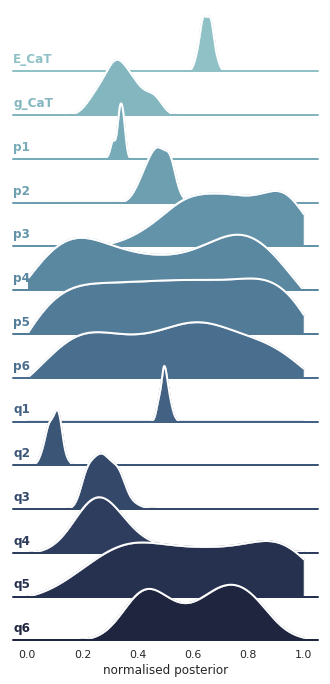

In [16]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits)

In [17]:
g.savefig('results/icat/parameters_kde.pdf')

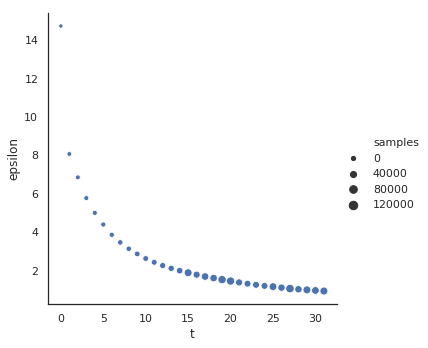

In [18]:
evolution = history.get_all_populations()
g = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
g.savefig('results/icat/eps_evolution.pdf')

# Samples for quantitative analysis

In [13]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [14]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


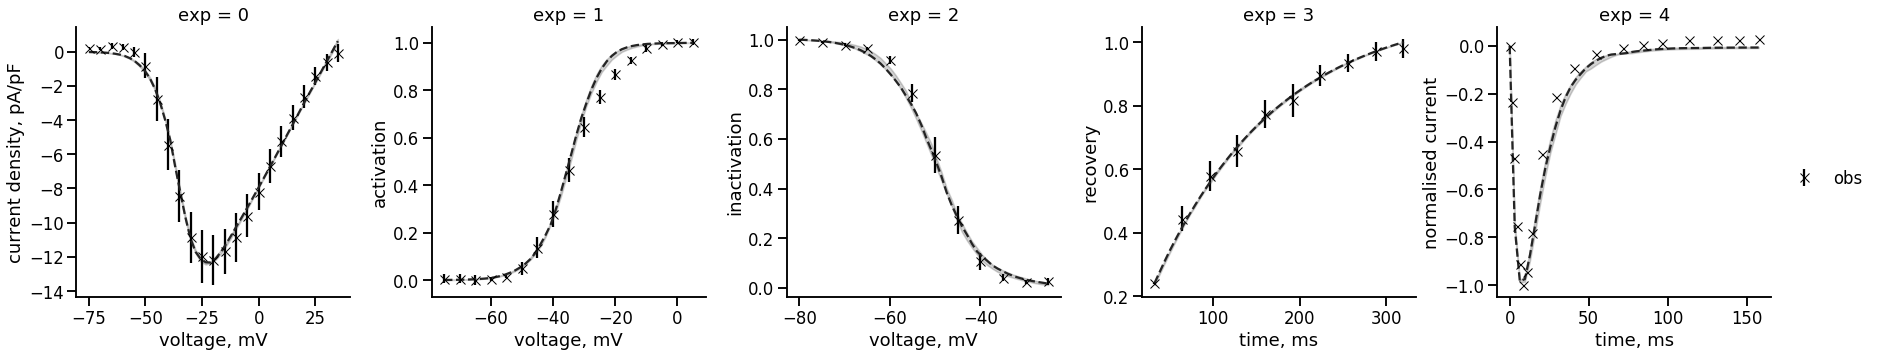

In [15]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms"]
ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [16]:
g.savefig('results/icat/icat_sim_results.pdf')

In [23]:
# Mean current density
print(np.mean(samples[samples.exp==0].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp==0].groupby('sample').min()['y']))

-12.34460856542707
0.3534975259246642


In [27]:
import scipy.stats as st
peak_current = samples[samples['exp']==0].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [44]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -23.367346938775512
95% CI: (-25.612244897959187, -21.122448979591837)


In [45]:
# Voltage of peak current density
idxs = samples[samples.exp==0].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -22.985714285714284
STD: 1.6513357081439421


In [46]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -23.367346938775512
95% CI: (-25.612244897959187, -21.122448979591837)


In [48]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [49]:
print(np.mean(output))
print(np.std(output))

0   -34.850753
1     5.178208
dtype: float64
0    0.799012
1    0.513063
dtype: float64


In [54]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -34.82690735774299
95% CI: (-36.24616305551558, -33.647015941723545)


In [55]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.183413011015754
95% CI: (4.3327653225812774, 6.264327761796811)


In [56]:
# Half activation potential
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [57]:
print(np.mean(output))
print(np.std(output))

0   -49.656801
1     5.233013
dtype: float64
0    1.513939
1    1.324139
dtype: float64


In [58]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -49.49689663027338
95% CI: (-53.45375263664067, -47.36140029622908)


In [59]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.323120724705627
95% CI: (2.6461977801435994, 7.9877735197046675)


In [60]:
# Recovery time constant
grouped = samples[samples.exp==3].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [61]:
print(np.mean(output))
print(np.std(output))

139.67532194215855
19.03046313547188


In [62]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 135.09347301648862
95% CI: (112.46514930386876, 185.93979875599535)


# Parameter sensitivity analysis

In [9]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

In [9]:
parameters = ['icat.'+k for k in limits.keys()]

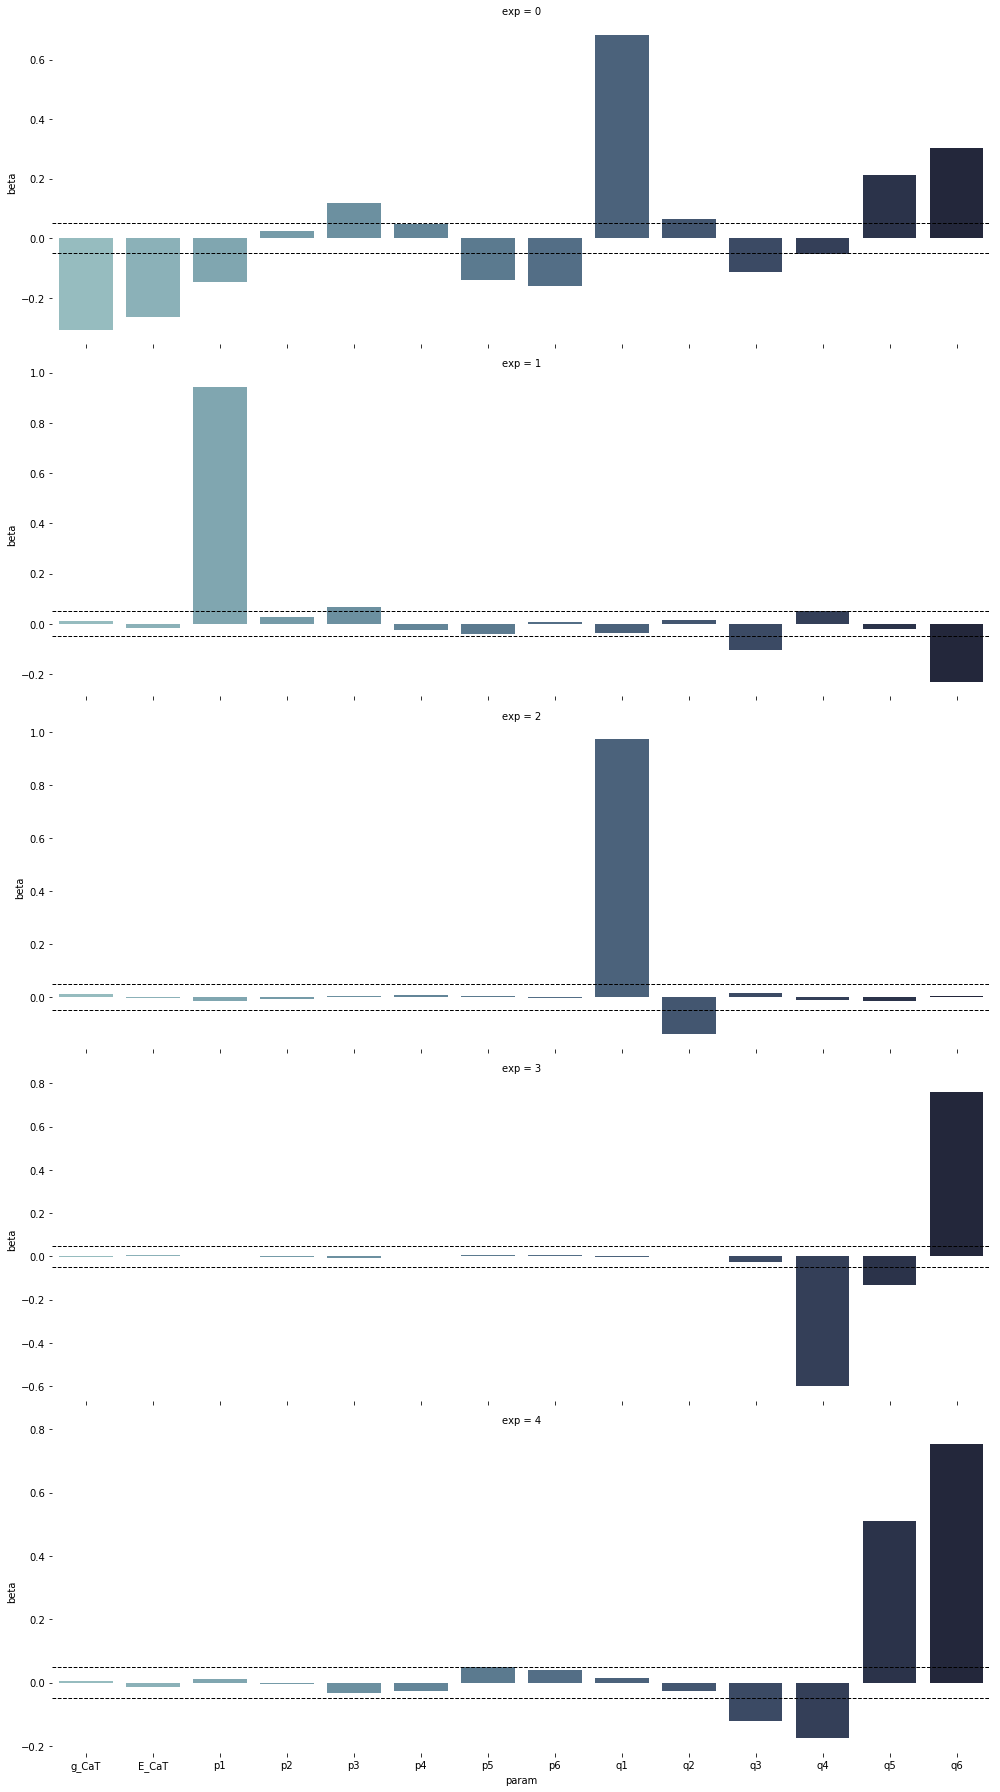

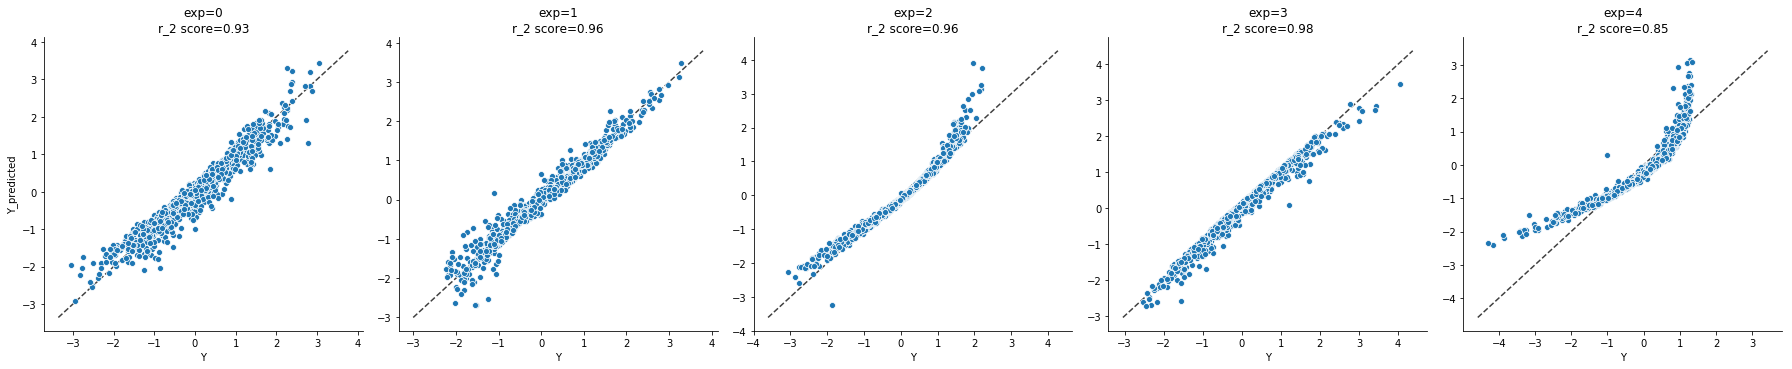

In [10]:
from ionchannelABC import plot_parameter_sensitivity
grid, grid2 = plot_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=1000,
    plot_cutoff=0.05)

In [11]:
grid.savefig('results/icat/sensitivity.pdf')

In [12]:
grid2.savefig('results/icat/sensitivity_fit.pdf')

# Weights of distance function

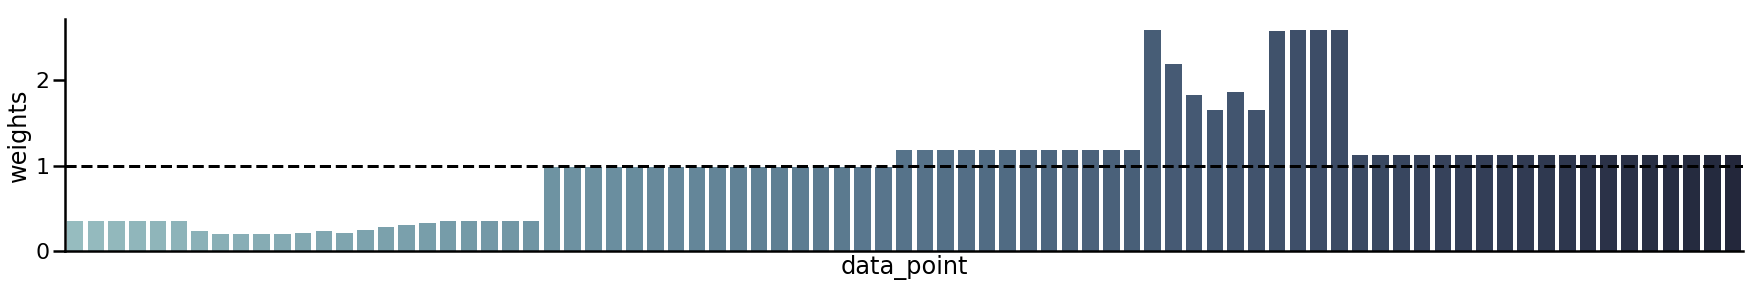

In [10]:
from ionchannelABC import plot_distance_weights
grid = plot_distance_weights(model, distance_fn)

In [11]:
grid.savefig('results/icat/dist_weights.pdf')